## Import Libraries and Config

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import random
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
NUM_CUSTOMERS = 50
NUM_CHARGERS = 10
NUM_VEHICLES = 5
DEPOT = 0
BATTERY_CAPACITY = 10  # max battery level
ENERGY_PER_KM = 0.187  # energy usage per km
TIME_PER_KM = 3 # time usage per km
MAX_TIME_PER_VEHICLE = 600  # max time per vehicle in minutes

## Random generate EV charging points and delivery locations

In [10]:
# Random seed for reproducibility
np.random.seed(5)

# -----------------------------
# Electric vehicle Points
# -----------------------------
ev_pts = pd.read_csv("Unique_EV_Points.csv")
charge_pts = ev_pts.sample(n=NUM_CHARGERS, random_state=5)[['Latitude', 'Longitude']]
charge_pts_list = list(charge_pts.itertuples(index=False, name=None))
# print(charge_pts_list)


# Delivery locations Points
# -----------------------------
dl = pd.read_csv("DeliveryLocations.csv")
## choose 100 locations
todays_locations = dl.sample(n=NUM_CUSTOMERS, random_state=5)[['latitude', 'longitude']]
dl_list = list(todays_locations.itertuples(index=False, name=None))

# print(dl_list)

# Fedex Ship Centre
fedex_centre = [(1.3731437, 104.0023106)]

locations = fedex_centre + dl_list + charge_pts_list
print(locations)

[(1.3731437, 104.0023106), (1.392836795, 103.9031463), (1.350675728, 103.7200224), (1.389594981, 103.743248), (1.321415897, 103.7671055), (1.438097638, 103.8396421), (1.321580687, 103.854151), (1.382904957, 103.8937135), (1.338132418, 103.701603), (1.369122417, 103.8516161), (1.393069499, 103.9106985), (1.444411907, 103.7958279), (1.32378355, 103.7385184), (1.376263241, 103.764451), (1.378930838, 103.9009883), (1.2823137, 103.8293115), (1.393322372, 103.9071162), (1.356294894, 103.8428226), (1.277395442, 103.8204697), (1.347666576, 103.7325787), (1.353848111, 103.8669618), (1.378238594, 103.8437197), (1.294642864, 103.808264), (1.403012767, 103.9068635), (1.303460962, 103.8507093), (1.3508614, 103.7254507), (1.363800158, 103.9534387), (1.430100193, 103.8331176), (1.355949453, 103.869581), (1.401126351, 103.9124627), (1.387862243, 103.8907051), (1.345540335, 103.9368755), (1.329245367, 103.9099237), (1.443282043, 103.7772942), (1.393398979, 103.8762905), (1.351856129, 103.7460768), (1.3

## Scatter plot of EV points, Depot, and customer locations

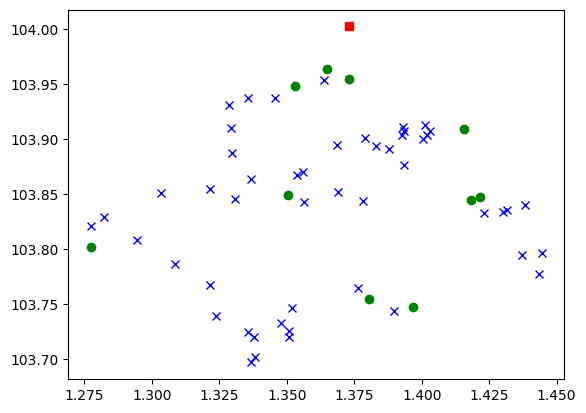

In [11]:
import matplotlib.pyplot as plt

for i, loc in enumerate(locations):
    if i == 0:
        plt.plot(loc[0], loc[1], color="red", marker="s")
    elif i <= NUM_CUSTOMERS:
        plt.plot(loc[0], loc[1], color="blue", marker="x")
    else:
        plt.plot(loc[0], loc[1], color="green", marker="o")


## Computing distance and energy matrices

This cell calculates the distance and energy required to travel between any two nodes.

- **`distance_matrix[i][j]`**: straight-line distance (in km) from node `i` to `j`.
- **`energy_matrix[i][j]`**: energy used (in kWh), assuming 1 kWh/km.

#### Node Indexing:
- `0` = depot
- `1` to `15` = customers
- `16` onward = charging stations

Distances are estimated using a basic formula where  
1 degree ≈ 111 km — accurate enough for local areas like Singapore.

In [12]:
# Total nodes: 1 depot + customers + chargers
n = len(locations)
customer_nodes = list(range(1, 1 + NUM_CUSTOMERS))
charger_nodes = list(range(1 + NUM_CUSTOMERS, n))

# -----------------------------
# Compute Distance & Energy Matrices
# -----------------------------
distance_matrix = np.zeros((n, n))
energy_matrix = np.zeros((n, n))
time_matrix = np.zeros((n, n))

def straight_line_distance(p1, p2):
    lat_diff = p1[0] - p2[0]
    lon_diff = p1[1] - p2[1]
    return 111 * np.sqrt(lat_diff**2 + lon_diff**2)

for i in range(n):
    for j in range(n):
        if i != j:
            dist = straight_line_distance(locations[i], locations[j])
            distance_matrix[i][j] = dist
            energy_matrix[i][j] = dist * ENERGY_PER_KM
            time_matrix[i][j] = dist * TIME_PER_KM
            

#print(distance_matrix[5])
distance_matrix.shape # size should be depot + no. of customers + no. of chargers
#print(energy_matrix[1]) # 26x26
#print(np.max(energy_matrix))

(61, 61)

In [15]:
model = gp.Model("EVRP")

# vehicle usage indicator
u = model.addVars(NUM_VEHICLES, vtype=GRB.BINARY, name="u")

# x[i,j,k] = 1 if vehicle k travels from i to j, we do NOT allow i == j
x = model.addVars(
        [(i, j, k)
         for i in range(n)
         for j in range(n) if i != j      # ← filter out i==j
         for k in range(NUM_VEHICLES)],
        vtype=GRB.BINARY, name="x")


# q[i,k] = battery level when vehicle k arrives at node i
q = model.addVars(n, NUM_VEHICLES, vtype=GRB.CONTINUOUS, lb=0, ub=BATTERY_CAPACITY, name="q")

# delta[i,k] = charging decision variable
delta = model.addVars(n, NUM_VEHICLES, lb=0, ub=BATTERY_CAPACITY, name="delta")

# variable for MTZ formulation
z = model.addVars(n, NUM_VEHICLES, vtype=GRB.CONTINUOUS, lb=0, ub=n-1, name="z")

# decision variable for time taken to travel from node i to j
t = model.addVars(n, n, NUM_VEHICLES, lb=0, vtype=GRB.CONTINUOUS, name="t")

# this sets nodes that are not at charging stations to be zero
for i in range(n):
    if i not in charger_nodes:
        for k in range(NUM_VEHICLES):
            model.addConstr(delta[i, k] == 0)

# 1: Each customer is visited exactly once
for j in customer_nodes:
    model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) if i != j for k in range(NUM_VEHICLES)) == 1)

# 2: Flow conservation for vehicle entering and leaving delivery point
for k in range(NUM_VEHICLES):
    for i in range(1, n):
        model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) ==
                        gp.quicksum(x[j, i, k] for j in range(n) if j != i))

# 3: Each vehicle starts and ends at depot
# for k in range(NUM_VEHICLES):
#     model.addConstr(gp.quicksum(x[DEPOT, j, k] for j in range(n) if j != DEPOT) == 1)
#     model.addConstr(gp.quicksum(x[i, DEPOT, k] for i in range(n) if i != DEPOT) == 1)
for k in range(NUM_VEHICLES):
    model.addConstr(gp.quicksum(x[0, j, k] for j in range(1, n)) == u[k])
    model.addConstr(gp.quicksum(x[i, 0, k] for i in range(1, n)) == u[k])

# 4: Battery dynamics
max_energy_needed = max(energy_matrix[i][j] for i in range(n) for j in range(n) if i != j)
M = BATTERY_CAPACITY + max_energy_needed  # upper bound for worst-case consumption

for k in range(NUM_VEHICLES):
    for i in range(n):
        for j in range(n):
            if i != j and j != DEPOT:
                model.addConstr(
                    q[j, k] >= q[i, k] - energy_matrix[i][j] * x[i, j, k] + delta[i, k] - (1 - x[i, j, k]) * M
                )
                model.addConstr(
                    q[j, k] <= q[i, k] - energy_matrix[i][j] * x[i, j, k] + delta[i, k] + (1 - x[i, j, k]) * M
                )
                
# 4.5: Prevent overcharging
for k in range(NUM_VEHICLES):
    for i in charger_nodes:
        model.addConstr(delta[i, k] <= BATTERY_CAPACITY - q[i, k])
                

# 5: Adds an upper bound for qik
for k in range(NUM_VEHICLES):
    for i in charger_nodes:
        # reset charge
        model.addConstr(q[i, k] <= BATTERY_CAPACITY)

# 6: Charged to full battery at depot
for k in range(NUM_VEHICLES):
    model.addConstr(q[DEPOT, k] == BATTERY_CAPACITY)
    
# 7: MTZ formulation to eliminate subtours, as well as ensuring vehicles start and leave at depot
for k in range(NUM_VEHICLES):
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                model.addConstr(
                    z[i, k] - z[j, k] + (n - 1) * x[i, j, k] <= n - 2,
                    name=f"MTZ_{i}_{j}_{k}"
                )
# Set depot ordering to 0 for each vehicle
for k in range(NUM_VEHICLES):
    model.addConstr(z[DEPOT, k] == 0)

# 8: Time constraints for each vehicle
for k in range(NUM_VEHICLES):
    model.addConstr(
        gp.quicksum(t[i, j, k] for i in range(n) for j in range(n) if i != j) <= MAX_TIME_PER_VEHICLE,
        name=f"time_limit_veh_{k}"
    )

# Link travel time to binary route variable
for i in range(n):
    for j in range(n):
        if i != j:
            for k in range(NUM_VEHICLES):
                model.addConstr(
                    t[i, j, k] == time_matrix[i][j] * x[i, j, k],
                    name=f"time_link_{i}_{j}_{k}"
                )


# Objective: minimize total distance
model.setObjective(gp.quicksum(distance_matrix[i][j] * x[i, j, k]
                               for i in range(n) for j in range(n) if i != j for k in range(NUM_VEHICLES)),
                   GRB.MINIMIZE)


### 🎯 Objective Function

**Minimize total distance traveled:**  
$$
\min \sum_{k \in K} \sum_{i \ne j} d_{ij} \cdot x_{ijk}
$$

---

### 📌 Decision Variables

Let:  
- $begin:math:text$ N $end:math:text$: set of all nodes (including depot $begin:math:text$ D $end:math:text$, customer nodes $begin:math:text$ C $end:math:text$, and charging stations $begin:math:text$ S $end:math:text$)  
- $begin:math:text$ K $end:math:text$: set of available vehicles  
- $begin:math:text$ B_{\\text{max}} $end:math:text$: battery capacity  

The decision variables are:

**Vehicle usage indicator**
$$
u_k \in \{0, 1\} \quad \forall k \in K
$$
1 if vehicle $begin:math:text$ k $end:math:text$ is used.

**Routing decision**
$$
x_{ijk} \in \{0, 1\} \quad \forall i, j \in N,\ i \ne j,\ \forall k \in K
$$
1 if vehicle $begin:math:text$ k $end:math:text$ travels from node $begin:math:text$ i $end:math:text$ to node $begin:math:text$ j $end:math:text$.

**Battery level**
$$
q_{ik} \in [0, B_{\text{max}}] \quad \forall i \in N,\ \forall k \in K
$$
Battery level of vehicle $begin:math:text$ k $end:math:text$ upon arrival at node $begin:math:text$ i $end:math:text$.

**Charging amount**
$$
\delta_{ik} \in [0, B_{\text{max}}] \quad \forall i \in N,\ \forall k \in K
$$
Amount of energy vehicle $begin:math:text$ k $end:math:text$ charges at node $begin:math:text$ i $end:math:text$. If $begin:math:text$ i \\notin S $end:math:text$, then $begin:math:text$ \\delta_{ik} = 0 $end:math:text$.

**Visit order (MTZ variable)**
$$
t_{ik} \in [0, |N|-1] \quad \forall i \in N,\ \forall k \in K
$$
Ordering of visits to eliminate subtours for vehicle $begin:math:text$ k $end:math:text$.

---

### 🔒 Constraints

**1. Each customer visited exactly once**  
$$
\sum_{k \in K} \sum_{i \in N,\ i \ne j} x_{ijk} = 1 \quad \forall j \in C
$$

**2. Flow conservation (non-depot nodes)**  
$$
\sum_{j \in N,\ j \ne i} x_{ijk} = \sum_{j \in N,\ j \ne i} x_{jik} \quad \forall i \in N \setminus D,\ \forall k \in K
$$

**3. Depot entry/exit linked to vehicle usage**  
$$
\sum_{j \in N \setminus D} x_{0jk} = u_k \quad \forall k \in K
$$  
$$
\sum_{i \in N \setminus D} x_{i0k} = u_k \quad \forall k \in K
$$

**4. Battery dynamics (big-M for charge)**  
$$
q_{jk} = q_{ik} - e_{ij} \cdot x_{ijk} + \delta_{ik} \quad \forall i \ne j,\ j \ne 0,\ \forall k \in K
$$

**4.5 Prevent overcharging**  
$$
\delta_{ik} \leq B_{\text{max}} - q_{ik} \quad \forall i \in S,\ \forall k \in K
$$

**5. Battery level must not exceed capacity**  
$$
q_{ik} \leq B_{\text{max}} \quad \forall i \in S,\ \forall k \in K
$$

**6. Battery full at depot**  
$$
q_{0k} = B_{\text{max}} \quad \forall k \in K
$$

**7. Subtour elimination (MTZ constraints)**  
$$
t_{ik} - t_{jk} + (n - 1)x_{ijk} \leq n - 2 \quad \forall i \ne j,\ i, j \in N \setminus D,\ \forall k \in K
$$  
$$
t_{0k} = 0 \quad \forall k \in K
$$

---


In [14]:
model.Params.TimeLimit = 300  # in seconds
# model.setParam('MIPGap', 0.1) # if gap is too small, stop the model from further optimizing
model.optimize()
print(model.Status)
if model.Status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL]:
    print("Solution found!")
    print("Objective value:", model.ObjVal)
else:
    print("No feasible solution.")
    print("Objective value:", model.ObjVal)
    
print("\n--- Routes ---")

total = 0
for k in range(NUM_VEHICLES):
    print(f"Vehicle {k + 1}:")
    for i in range(n):
        for j in range(n):
            if i != j and x[i, j, k].X > 0.5:
                print(f"  {i} → {j}")
                total += t[i,j,k].X

print(total)

Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7700 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 72730 rows, 37825 columns and 304025 nonzeros
Model fingerprint: 0x7c10ad6f
Variable types: 19520 continuous, 18305 integer (18305 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+02]
Presolve removed 18615 rows and 18870 columns
Presolve time: 0.23s
Presolved: 54115 rows, 18955 columns, 236205 nonzeros
Variable types: 650 continuous, 18305 integer (18305 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 54115 rows, 18955 columns, 236

In [16]:
times = []
obj_vals = []
bounds = []

def callback(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        
        # Only store finite values
        if objbst < GRB.INFINITY and objbnd < GRB.INFINITY:
            times.append(runtime)
            obj_vals.append(objbst)
            bounds.append(objbnd)


model.Params.TimeLimit = 300  # in seconds
# model.setParam('MIPGap', 0.1) # if gap is too small, stop the model from further optimizing
model.optimize(callback)

Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7700 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 72730 rows, 37825 columns and 304025 nonzeros
Model fingerprint: 0x7c10ad6f
Variable types: 19520 continuous, 18305 integer (18305 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+02]
Presolve removed 18615 rows and 18870 columns
Presolve time: 0.24s
Presolved: 54115 rows, 18955 columns, 236205 nonzeros
Variable types: 650 continuous, 18305 integer (18305 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 54115 rows, 18955 columns, 236

In [17]:
data = {'run': "Gurobi Optimizer", 
    # 'iterations': iterations, 
    'costs': obj_vals,
    'cpu_times': times,
    'lbound': bounds}

import json
with open('Benchmark_50_10_5.json', 'a') as file:
    file.write(json.dumps(data) + '\n')

In [7]:
# -------------------------------------------------
# Handy checker for one hand-crafted solution
# -------------------------------------------------
routes = {
    1: [0, 3,  1, 13,  7, 10, 0],   # vehicle-ID : tour
    2: [0, 8,  6, 15, 11, 12, 0],
    3: [0, 9,  2,  5,  4, 14, 0],
}

def check_solution(routes):
    """routes = {veh_id : [0, … , 0], … }"""

    # ------- 1. customer coverage -----------------
    visited = []
    for tour in routes.values():
        visited += [n for n in tour if n in customer_nodes]

    missing   = set(customer_nodes) - set(visited)
    repeated  = [n for n in visited if visited.count(n) > 1]

    # ------- 2. arc usage (for reverse-arc test) ---
    arc_owner = {}              # (i,j) -> veh that uses it
    reverse_conflicts = []      # [(i,j,k1,k2), …]

    # ------- 3. per-vehicle checks ----------------
    reports = []
    for k, tour in routes.items():

        batt     = BATTERY_CAPACITY
        batt_ok  = True
        t_tot    = 0.0

        for i, j in zip(tour, tour[1:]):
            # -------- reverse-arc bookkeeping -----
            if (j, i) in arc_owner:
                reverse_conflicts.append((i, j, k, arc_owner[(j, i)]))
            arc_owner[(i, j)] = k
            # ---------------------------------------

            # ---- simple battery & time update -----
            if i in charger_nodes:
                batt = BATTERY_CAPACITY           # fill up before leaving i

            batt -= energy_matrix[i, j]
            if batt < 0:
                batt_ok = False

            t_tot += time_matrix[i, j]

        reports.append(dict(veh=k,
                            batt_ok=batt_ok,
                            time_ok=t_tot <= MAX_TIME,
                            time=t_tot,
                            last_batt=batt))

    # -------------- summary print-out ---------------
    print("• Missing customers :", sorted(missing))
    print("• Repeated customers:", sorted(set(repeated)))

    if reverse_conflicts:
        print("\n⚠️  Reverse-arc DUPLICATES found:")
        for i, j, k_fwd, k_rev in reverse_conflicts:
            print(f"   arc ({i},{j}) in veh {k_fwd}  &  "
                  f"arc ({j},{i}) in veh {k_rev}")
    else:
        print("\n✓  No reverse-arc duplicates")

    for r in reports:
        print(f"Veh {r['veh']}: time {r['time']:.1f} "
              f"({'OK' if r['time_ok'] else 'FAIL'}), "
              f"battery at end {r['last_batt']:.1f} "
              f"({'OK' if r['batt_ok'] else 'FAIL'})")
    
    # -------------------------------------------------
    #  OPTIONAL: detailed time trace for every vehicle
    # -------------------------------------------------
    print("\n──────────  per-vehicle time breakdown  ──────────")
    for k, tour in routes.items():
        print(f"\nVehicle {k}")
        cum = 0.0
        print("  leg        t(i,j)   cum-time")
        for i, j in zip(tour, tour[1:]):
            tij  = time_matrix[i, j]
            cum += tij
            print(f"  {i:>2} → {j:<2}   {tij:6.1f}   {cum:7.1f}")
        print(f"  total time = {cum:.1f}  "
              f"({'OK' if cum <= MAX_TIME else 'OVER'})")

check_solution(routes)

• Missing customers : []
• Repeated customers: []

✓  No reverse-arc duplicates
Veh 1: time 97.9 (OK), battery at end 42.2 (OK)
Veh 2: time 130.7 (FAIL), battery at end 36.2 (OK)
Veh 3: time 99.7 (OK), battery at end 41.9 (OK)

──────────  per-vehicle time breakdown  ──────────

Vehicle 1
  leg        t(i,j)   cum-time
   0 → 3      31.7      31.7
   3 → 1      19.5      51.2
   1 → 13     17.1      68.3
  13 → 7      15.8      84.1
   7 → 10      2.4      86.5
  10 → 0      11.4      97.9
  total time = 97.9  (OK)

Vehicle 2
  leg        t(i,j)   cum-time
   0 → 8      37.0      37.0
   8 → 6      18.7      55.7
   6 → 15      5.7      61.4
  15 → 11     20.2      81.6
  11 → 12     16.3      97.9
  12 → 0      32.8     130.7
  total time = 130.7  (OVER)

Vehicle 3
  leg        t(i,j)   cum-time
   0 → 9      18.4      18.4
   9 → 2      16.2      34.6
   2 → 5      18.1      52.7
   5 → 4      16.8      69.5
   4 → 14     17.8      87.3
  14 → 0      12.4      99.7
  total time = 99.

In [79]:
times = []
obj_vals = []
bounds = []

def callback(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        
        # Only store finite values
        if objbst < GRB.INFINITY and objbnd < GRB.INFINITY:
            times.append(runtime)
            obj_vals.append(objbst)
            bounds.append(objbnd)


model.Params.TimeLimit = 300  # in seconds
model.setParam('MIPGap', 0.1) # if gap is too small, stop the model from further optimizing
model.optimize(callback)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.1

Optimize a model with 7839 rows, 4374 columns and 40224 nonzeros
Model fingerprint: 0xa20b1e58
Variable types: 312 continuous, 4062 integer (4062 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 7e+01]
Presolved: 7677 rows, 4116 columns, 49482 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 5
  Lift-and-project: 4
  Cover: 6
  Implied bound: 78
  MIR: 56
  RLT: 81
  Relax-and-lift: 41

Explored 1 nodes (1945 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 10: 62.5984 66.9229 67.8343 

In [75]:
# -----------------------------
# Extract Vehicle Routes
# -----------------------------
if model.Status == GRB.OPTIMAL:
    print("Optimal routes found:")
else:
    print("Not most optimal yet")

ccs = [
    'r', 'g', 'y', 'm', 'b', 'k', 'm', 'w', 'b', 'g'
]
for k in range(NUM_VEHICLES):
    current_node = DEPOT
    route = [DEPOT]
    recharging_stops = 0
    total_dist = 0

    while True:
        next_node = None
        for j in range(n):
            if j != current_node and x[current_node, j, k].X > 0.5:
                next_node = j
                break
        if next_node is None or next_node == DEPOT:
            break
        route.append(next_node)
        x1,y1 = locations[current_node]
        x2,y2 = locations[next_node]

        dist = distance_matrix[current_node][next_node]
        total_dist += dist
        
        if next_node >= NUM_CUSTOMERS:
            recharging_stops += 1
            total_dist = 0

        plt.plot([x1,x2],[y1,y2],'--', color=ccs[k])

        current_node = next_node
    
    plt.plot([x1,x2],[y1,y2],'--', color=ccs[k], label=f'EV {k+1}')

    route.append(DEPOT)

    print(f"Vehicle {k + 1}: {route}. # of Recharging Stops: {recharging_stops}")

    for r in range(len(route)-1):
        print(f"Distance: {distance_matrix[route[r]][route[r+1]]}")


    print("------------------ \n ")


for i, loc in enumerate(locations):
    if i <= max(customer_nodes):
        plt.plot(loc[0], loc[1], color="blue", marker="x")
    else:
        plt.plot(loc[0], loc[1], color="green", marker="o")

plt.plot(locations[0][0], locations[0][1], color="red", marker="s")
plt.legend()


Optimal routes found:


NameError: name 'x1' is not defined

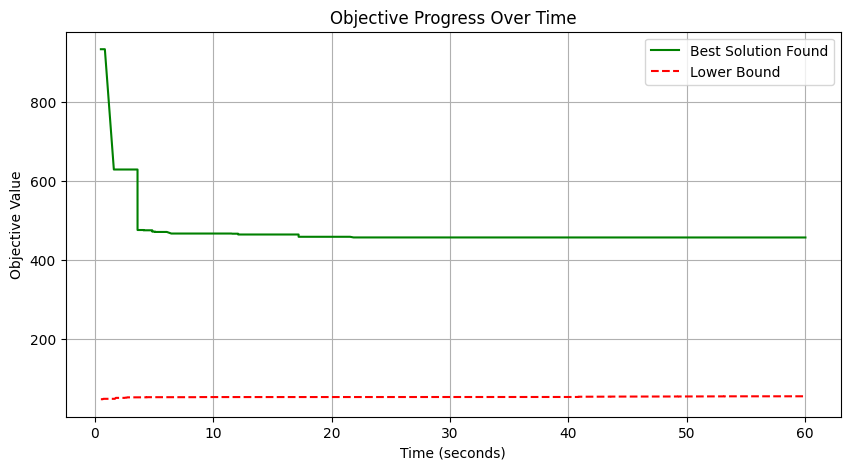

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(times, obj_vals, label="Best Solution Found", color='green')
plt.plot(times, bounds, label="Lower Bound", color='red', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Objective Value")
plt.title("Objective Progress Over Time")
plt.legend()
plt.grid(True)
plt.show()